In [1]:
import copy
import pickle

import ajf_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ajf_bridge_fem import *
from pandarallel import pandarallel
from scipy import stats

import ajf_plts

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load temperature data

In [2]:
keep_cols = ["air_temperature", "year", "seq_month", "day", "hour"]
temp_data = pd.read_parquet("temp-freq-e_val.parquet").loc[:, keep_cols]

In [3]:
temp_data

,air_temperature,year,seq_month,day,hour
0,3.9,0,0,1,0
1,4.7,0,0,1,1
2,5.0,0,0,1,2
3,4.8,0,0,1,3
4,4.2,0,0,1,4
...,...,...,...,...,...
534715,12.7,60,731,31,19
534716,12.9,60,731,31,20
534717,12.7,60,731,31,21
534718,12.2,60,731,31,22


# Load result data 

In [4]:
DAM_LOCS = ["L", "R"]
RUN_ID = "2023-01-29T12:51:27.214729_LB_0.02-step-delta"

all_data = (
    pd.read_parquet(f"./{RUN_ID}_w_error")
    .sort_values(["year", "delta"])
    .reset_index(drop=True)
)

all_data.head()

,seq_month,year,month,day,hour,minute,dayofweek,air_temperature,freq,E_val,...,S1,S2,S3,S4,S5,speed,x_dam,delta,L,R
0,0,0,0,1,1,36,6,4.880000,5.786878,2.883737e+10,...,3.75,9.60,10.85,NaN,NaN,23.0,11.333333,0.0,0.000089,0.000090
1,0,0,0,1,4,43,6,3.555000,5.795990,2.892656e+10,...,4.50,5.85,NaN,NaN,NaN,24.0,11.333333,0.0,0.000128,0.000125
2,0,0,0,1,5,10,6,3.216667,5.799653,2.896242e+10,...,5.20,6.55,NaN,NaN,NaN,28.0,11.333333,0.0,0.000062,0.000061
3,0,0,0,1,5,12,6,3.200000,5.799898,2.896483e+10,...,5.95,7.45,NaN,NaN,NaN,27.5,11.333333,0.0,0.000112,0.000113
4,0,0,0,1,6,57,6,3.655000,5.801216,2.897772e+10,...,6.05,NaN,NaN,NaN,NaN,25.5,11.333333,0.0,0.000062,0.000061


# Only keep columns we need to speed up computation

In [5]:
keep_cols = [
    "delta",
    "seq_month",
    "year",
    "month",
    "day",
    "hour",
    "AxleCount",
    "air_temperature",
] + DAM_LOCS
res_data = all_data.loc[:, keep_cols]

res_data

,delta,seq_month,year,month,day,hour,AxleCount,air_temperature,L,R
0,0.0,0,0,0,1,1,4,4.880000,0.000089,0.000090
1,0.0,0,0,0,1,4,3,3.555000,0.000128,0.000125
2,0.0,0,0,0,1,5,3,3.216667,0.000062,0.000061
3,0.0,0,0,0,1,5,3,3.200000,0.000112,0.000113
4,0.0,0,0,0,1,6,2,3.655000,0.000062,0.000061
...,...,...,...,...,...,...,...,...,...,...
67286533,0.2,731,60,11,31,22,5,12.200000,0.000095,0.000086
67286534,0.2,731,60,11,31,22,4,12.200000,0.000158,0.000148
67286535,0.2,731,60,11,31,22,2,12.200000,0.000047,0.000043
67286536,0.2,731,60,11,31,23,6,12.200000,0.000153,0.000138


# Apply air temperature sampling

In [6]:
AXLE_DICT = {"All": np.arange(2, 7), "5ax": np.arange(5, 6), "6ax": np.arange(6, 7)}
PROPORTION = 0.125

In [135]:
import statsmodels.api as sm

In [204]:
temp_baseline = temp_data.loc[temp_data.year == 0]
temp_dist = ajf_utils.get_rv_hist(temp_baseline.air_temperature)

In [198]:
kde = sm.nonparametric.KDEUnivariate(temp_baseline.air_temperature).fit()
kde_support = kde.support
kde_pdf = np.diff(kde.cdf, prepend=0.0)
kde_cdf = kde.cdf
temp_step = 0.1

In [243]:
def temp_pdf(temps):
    temps = np.array(temps)
    lower = np.interp(temps - 0.05, kde_support, kde_cdf, left=0.0, right=1.0)
    upper = np.interp(temps + 0.05, kde_support, kde_cdf, left=0.0, right=1.0)
    return upper - lower

In [215]:
temp_pdf(1.02)

0.002231974811872671

In [214]:
temp_dist.pdf(1.01)

0.02578685583822576

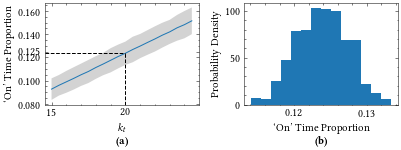

In [220]:
N_reps = 400

plt.style.use(
    [
        "./ajf_plts/base.mplstyle",
        "./ajf_plts/legend_frame.mplstyle",
        "./ajf_plts/lines_markers.mplstyle",
    ]
)


figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=2)
axes = axes.ravel()

kts = np.arange(15, 25, 0.5)
on_props = []
for kt in kts:
    on_props.append(
        [
            (
                np.random.uniform(size=len(temp_baseline.air_temperature))
                < (kt * temp_pdf(temp_baseline.air_temperature))
            ).sum()
            / len(temp_baseline.air_temperature)
            for _ in range(N_reps)
        ]
    )

means = np.mean(on_props, axis=1)
stds = np.std(on_props, axis=1)

kt_int = np.arange(1.2, 2.2, 0.01)
kt_int = kts
int_means = np.interp(kt_int, kts, means)
int_stds = np.interp(kt_int, kts, stds)

axes[0].plot(kt_int, int_means, marker="")
axes[0].fill_between(
    kt_int,
    int_means - 3.0 * int_stds,
    int_means + 3.0 * int_stds,
    fc="lightgrey",
    zorder=-100,
)

opt_ind = np.abs(int_means - PROPORTION).argmin()
opt_kt = kt_int[opt_ind]
opt_mean = int_means[opt_ind]

xlims = axes[0].get_xlim()
xlim_range = xlims[1] - xlims[0]

ylims = axes[0].get_ylim()
ylim_range = ylims[1] - ylims[0]

# axes[0].set_xticks(list(axes[0].get_xticks()) + [opt_kt])
axes[0].set_yticks(list(axes[0].get_yticks()) + [PROPORTION])

axes[0].axhline(
    y=opt_mean,
    xmin=0,
    xmax=(opt_kt - xlims[0]) / xlim_range,
    ls="--",
    color="k",
)
axes[0].axvline(
    x=opt_kt,
    ymin=0,
    ymax=(opt_mean - ylims[0]) / ylim_range,
    ls="--",
    color="k",
)
axes[0].set_xlim(xlims)
axes[0].set_ylim(ylims)

axes[0].set_xlabel("$k_t$")
axes[0].set_ylabel("`On' Time Proportion")

opt_props = [
    (
        np.random.uniform(size=len(temp_baseline.air_temperature))
        < (opt_kt * temp_pdf(temp_baseline.air_temperature))
    ).sum()
    / len(temp_baseline.air_temperature)
    for _ in range(N_reps)
]
axes[1].hist(opt_props, bins=ajf_utils.get_FD_n_bins(opt_props), density=True)

axes[1].set_xlabel("`On' Time Proportion")
axes[1].set_ylabel("Probability Density")

ajf_plts.caption_axes(axes)
fig.tight_layout()

In [221]:
import time

from scipy import optimize

In [244]:
def calc_on_prop(k, data):
    on_props = np.array(
        [np.random.uniform(size=len(data)) < k * temp_pdf(data) for _ in range(10)]
    )
    return np.median(on_props.sum(axis=1) / len(data))


def loss(k, data):
    return np.abs(calc_on_prop(k, data) - PROPORTION)


res = optimize.minimize_scalar(
    loss, args=[temp_data[temp_data.year == 0].air_temperature], tol=1e-5
)

In [304]:
RNG = ajf_plts.get_rng("7e_air_temp_only.ipynb")


def get_samp_tups(df):
    res = optimize.minimize_scalar(loss, args=[df.air_temperature], tol=1e-4)
    k = res.x
    desired_N = int(PROPORTION * len(df))
    k_probs = k * temp_pdf(df.air_temperature)
    mask = np.array(len(df) * [False])
    while mask.sum() < desired_N:
        mask += RNG.uniform(size=len(df)) < k_probs
    samp_times = df[mask].loc[:, ["seq_month", "day", "hour"]]
    return samp_times.apply(tuple, axis=1).sample(n=desired_N, random_state=RNG)

In [305]:
# Don't do this in parallel as it involves random numbers!
samp_tups = temp_data.groupby(["seq_month"]).apply(get_samp_tups)

In [306]:
df = res_data.set_index(["seq_month", "day", "hour"])
samp_data = df.loc[df.index.isin(samp_tups)]

# Sample size

In [307]:
AXLE_NUMS = [np.arange(2, 7), np.arange(5, 6), np.arange(6, 7)]
AXLE_NAMES = ["All", "5ax", "6ax"]

for axles, n in zip(AXLE_NUMS, AXLE_NAMES):
    count_stats = (
        samp_data.loc[(samp_data.delta == 0) & samp_data.AxleCount.isin(axles)]
        .groupby("year")
        .agg("count")
        .agg(["mean", "median", "std"])
        .iloc[:, 0]
    )
    print(
        n,
        f"\\num{{{count_stats.loc['mean']:.0f}}}\,(\\num{{{count_stats.loc['std']:.1f}}})",
    )

All \num{12317}\,(\num{338.2})
5ax \num{4181}\,(\num{119.6})
6ax \num{1538}\,(\num{64.4})


# On Time

In [308]:
N_on = samp_tups.groupby("seq_month").apply(lambda g: len(g.index.unique()))
N_all = temp_data.groupby("seq_month").apply(lambda g: len(g.index.unique()))

In [309]:
prop_on = N_on / N_all
np.mean(prop_on), np.std(prop_on)

(0.125, 0.0)

# Extract baselines

In [315]:
baseline_full

,delta,seq_month,year,month,day,hour,AxleCount,air_temperature,L,R
0,0.0,0,0,0,1,1,4,4.880000,0.000089,0.000090
1,0.0,0,0,0,1,4,3,3.555000,0.000128,0.000125
2,0.0,0,0,0,1,5,3,3.216667,0.000062,0.000061
3,0.0,0,0,0,1,5,3,3.200000,0.000112,0.000113
4,0.0,0,0,0,1,6,2,3.655000,0.000062,0.000061
...,...,...,...,...,...,...,...,...,...,...
99695,0.0,11,0,11,31,22,6,0.106667,0.000164,0.000160
99696,0.0,11,0,11,31,22,5,0.095000,0.000110,0.000111
99697,0.0,11,0,11,31,22,2,-0.278333,0.000060,0.000060
99698,0.0,11,0,11,31,23,2,-2.020000,0.000068,0.000065


In [310]:
baseline_full = res_data.loc[(res_data.year == 0) & (res_data.delta == 0.0)]

baseline_samp = samp_data.loc[(samp_data.year == 0) & (samp_data.delta == 0.0)]

In [311]:
def calc_emd(df):
    return dict(
        zip(
            [l + "_" + n for n in AXLE_NAMES for l in DAM_LOCS],
            [
                stats.wasserstein_distance(
                    baseline.loc[baseline.AxleCount.isin(axles), l].values,
                    df.loc[df.AxleCount.isin(axles), l].values,
                )
                for axles in AXLE_NUMS
                for l in DAM_LOCS
            ],
        )
    )


# sampled
# del baseline
baseline = baseline_samp  # ugly hack to get around pandarallel
emd_vals = samp_data.groupby(["delta", "year"]).parallel_apply(calc_emd)
emd_samp_df = pd.DataFrame(
    emd_vals.to_list(),
    index=emd_vals.index,
).dropna()
emd_samp_df *= 1e6  # convert to urad

# Plot Graphs

## Prediction interval plots

In [312]:
from importlib import reload

ajf_utils = reload(ajf_utils)

### Sampled baseline

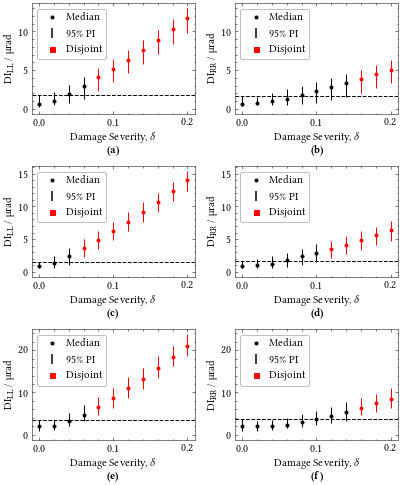

In [313]:
fig = ajf_utils.plot_pi(emd_samp_df.reset_index(), DAM_LOCS)
ajf_plts.save_fig(fig, "figAirTempPIPlotsSamp.pdf")

# Table of stats tests

### Sampled baseline

In [314]:
tab = ajf_utils.format_pred_int_table(emd_samp_df, DAM_LOCS)
with open("./output/tabAirTempPIsSamp.tex", "w") as f:
    f.write(tab)
print(tab)

\begin{tabular}{lcccccc}

    \toprule
    {    } & \multicolumn{3}{c}{$\DI{LL}$ (\unit{\micro\radian})} & \multicolumn{3}{c}{$\DI{RR}$ (\unit{\micro\radian})}\\
    \cmidrule(lr){2-4} \cmidrule(lr){5-7}
    $\delta$ & All &  5-axle & 6-axle &  All & 5-axle &  6-axle\\
    \midrule
    0.00 & (0.27, 1.72) & (0.534, 1.52) & (0.804, 3.54) & (0.312, 1.67) & (0.544, 1.64) & (0.888, 3.63)\\
0.02 & (0.46, 2.11) & (0.536, 2.45) & (1.18, 3.41) & (0.413, 1.56) & (0.565, 1.93) & (0.936, 3.28)\\
0.04 & (0.705, 3.1) & (1.05, 3.64) & (2.16, 5.06) & (0.477, 2.0) & (0.602, 2.43) & (1.18, 3.38)\\
0.06 & (1.28, 4.16) & \bfseries(2.25, 4.93) & (3.15, 7.14) & (0.516, 2.51) & (0.725, 2.93) & (1.51, 3.87)\\
0.08 & \bfseries(2.3, 5.27) & \bfseries(3.41, 6.2) & \bfseries(4.56, 9.03) & (0.609, 2.95) & (1.04, 3.54) & (1.8, 4.89)\\
0.10 & \bfseries(3.44, 6.42) & \bfseries(4.79, 7.64) & \bfseries(6.36, 11.1) & (0.788, 3.42) & (1.52, 4.17) & (2.28, 5.64)\\
0.12 & \bfseries(4.63, 7.62) & \bfseries(6.29, 9.11) & \b